<a href="https://colab.research.google.com/github/HUSILEBAI/GEOG-5410/blob/main/GEOG_5410_EOF_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAO index

This is the practise code for climate mode analysis. Start with connecting your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Sea Level Pressure (SLP) data
* Now, let's download the data using <button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">!curl -O -C</button> command. Here, we use [NCEP/DOE Reanalysis II](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html).

* Note that you only need to run this section once. And you can turn it off after you have your data downloaded.

In [ ]:
# !curl -O -C - https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/Monthlies/surface/mslp.mon.mean.nc

In [ ]:
#!pip install cartopy eofs


In [5]:
import glob
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Now use [xarray.open_dataset](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) to read monthly mean sea surface pressure dataset.

* When you only need to read single file, do <br>
<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">xarray.open_dataset("file_name.nc")</button>

* When you need to read multiple files, do <br>
<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">xfile = sorted(glob.glob(file_name))</button> <br>
<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">mslp_dat = xr.open_dataset(file[0])</button>

In [6]:
file_name = f"mslp.mon.mean.nc"
mslp_dat = xr.open_dataset(file_name)
mslp_dat


<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, time: 542, nbnds: 2)
Coordinates:
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    mslp       (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by Hoop (netCDF2.3)\nConverted to chunked...

In [7]:
# Reverse the latitude dimension
mslp_dat_reversed_lat = mslp_dat.isel(lat=slice(None, None, -1))
mslp_dat_reversed_lat

<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, time: 542, nbnds: 2)
Coordinates:
  * lat        (lat) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    mslp       (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by Hoop (netCDF2.3)\nConverted to chunked...

In [8]:

# Read the data
lat = mslp_dat_reversed_lat.lat
lon = mslp_dat_reversed_lat.lon
mslp = mslp_dat_reversed_lat.mslp
print(f"Shape of latitude data is {lat.shape}")
print(f"Shape of longitude data is {lon.shape}")
print(f"Shape of mean sea surface pressure data is {mslp.shape}\n")
# print(f"latitude is {lat}")

Shape of latitude data is (73,)
Shape of longitude data is (144,)
Shape of mean sea surface pressure data is (542, 73, 144)



### NAO calculation
Here we use [Hurrell North Atlantic Oscillation (NAO) Index (PC-based)](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based) to compute the NAO.

<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">DJF mean</button>
<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lat_lim = [20 80]</button>
<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lon_lim = [-90 40]</button>


In [15]:
# extract DJF mslp
mslp_DJF = mslp.where(mslp['time.season']=='DJF', drop=True)
print(f"Shape of mean sea surface pressure data in DJF is {mslp_DJF.shape}")

Shape of mean sea surface pressure data in DJF is (137, 73, 144)


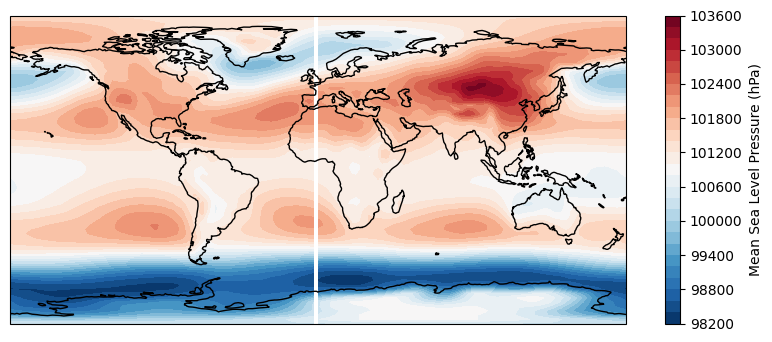

In [56]:
mslp_DJF_mean = mslp_DJF.mean('time')

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1,
                          projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
cb = ax.contourf(lon, lat, mslp_DJF_mean, levels = 30,
                 transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
# Add colorbar
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Mean Sea Level Pressure (hPa)')

plt.show()

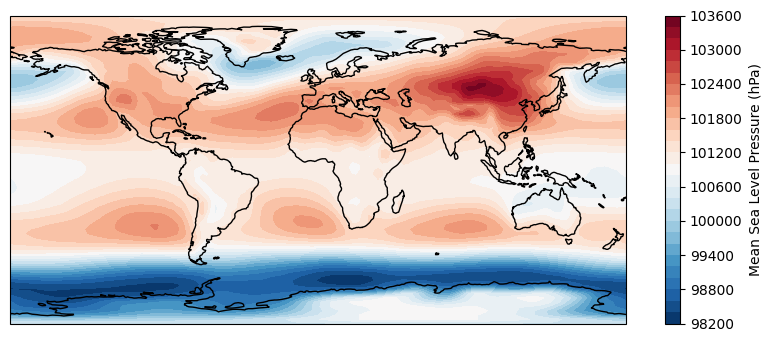

In [55]:
import cartopy.util as cutil
cdata, clon, clat = cutil.add_cyclic(mslp_DJF_mean, lon, lat)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1,
                          projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
cb = ax.contourf(clon, clat, cdata, levels = 30,
                 transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
# Add colorbar
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Mean Sea Level Pressure (hPa)')
plt.show()

In [40]:
# slice the mslp
lat_slice = slice(20, 80) # if slice(20, 80, -1) -1 is to reverse the latitude dimension

# Define the longitude slicing ranges
lon_slice1 = slice(270, 360)  # Slicing from 270°E to 360°E
lon_slice2 = slice(0, 40)  # Slicing from 0°E to 40°E

# Slice the data along the longitude dimension for each range
mslp_DJF_subset1 = mslp_DJF.sel(lat=lat_slice, lon=lon_slice1)
mslp_DJF_subset2 = mslp_DJF.sel(lat=lat_slice, lon=lon_slice2)

# Concatenate the subsets along the longitude dimension
mslp_DJF_subset = xr.concat([mslp_DJF_subset1, mslp_DJF_subset2], dim='lon')

print(f"Shape of subset of mean sea surface pressure data in DJF is {mslp_DJF_subset.shape}")

Shape of subset of mean sea surface pressure data in DJF is (137, 25, 53)


### EOF analysis

You might need to install eofs package in your colab env. Please run this <button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">!pip install eofs</button>  and install eof function first.

In [41]:
from eofs.xarray import Eof

In [42]:
# Calculate the anomaly of mslp_DJF_subset
mslp_DJF_anomaly = mslp_DJF_subset - mslp_DJF_subset.mean(dim='time')
print(f"Shape of anomaly of the DJF mean sea surface pressure data is {mslp_DJF_anomaly.shape}")

Shape of anomaly of the DJF mean sea surface pressure data is (137, 25, 53)


In [43]:
# Create an EOF solver
solver = Eof(mslp_DJF_anomaly.transpose('time', 'lat', 'lon'))

In [44]:
# Retrieve the leading EOF (EOF 1)
eof1 = solver.eofsAsCorrelation(neofs=1)
# Retrieve the PC time series of the leading EOF
pc1 = solver.pcs(npcs=1, pcscaling=1)
# Normalize the NAO index
nao_index_normalized = (pc1.values[:, 0] - np.mean(pc1.values[:, 0])) / np.std(pc1.values[:, 0])

# Print the shape of EOF1 and PC1
print("Shape of EOF 1:", eof1.shape)
print("Shape of PC 1:", pc1.shape)
print("Shape of NAO index:", nao_index_normalized.shape)


Shape of EOF 1: (1, 25, 53)
Shape of PC 1: (137, 1)
Shape of NAO index: (137,)


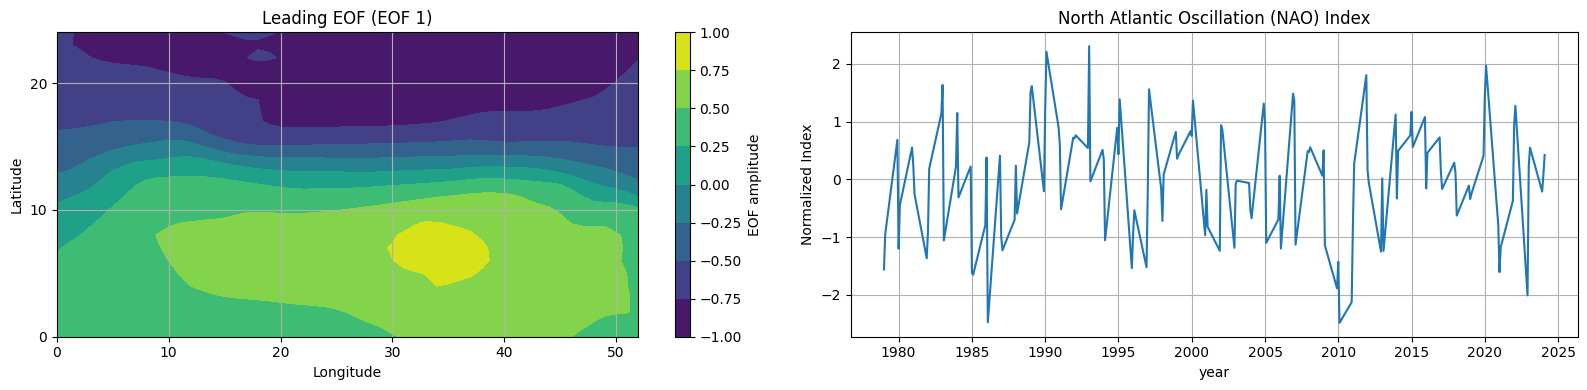

In [58]:
# Plot the leading EOF (EOF 1)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot the EOF
im = axes[0].contourf(eof1[0, :, :])
fig.colorbar(im, ax=axes[0], label='EOF amplitude')
axes[0].set_title('Leading EOF (EOF 1)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_xticks(range(0, eof1.shape[2] + 1, 10))
axes[0].set_yticks(range(0, eof1.shape[1] + 1, 10))
axes[0].grid(True)

# Plot the NAO index time series
axes[1].plot(pc1.time, nao_index_normalized)
axes[1].set_title('North Atlantic Oscillation (NAO) Index')
axes[1].set_xlabel('year')
axes[1].set_ylabel('Normalized Index')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [47]:
# Calculate the Pearson correlation coefficient using NumPy and xarray
corr_coef = xr.corr(mslp_DJF, xr.DataArray(nao_index_normalized, dims='time'), dim='time')

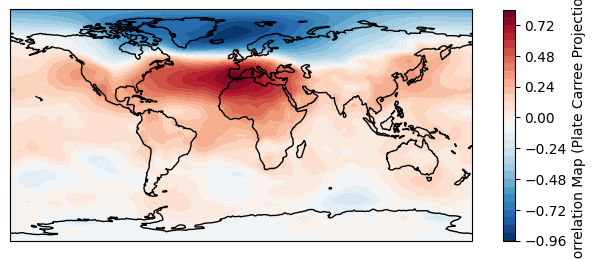

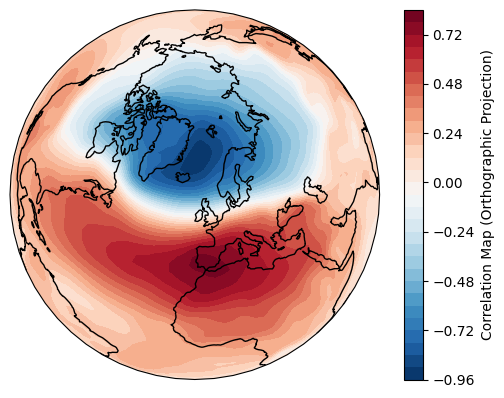

In [54]:
cdata, clon, clat = cutil.add_cyclic(corr_coef, lon, lat)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
cb = ax.contourf(clon, clat, cdata, levels = 30, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Correlation Map (Plate Carree Projection)')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=60))
ax.set_global()
cb = ax.contourf(clon, clat, cdata, levels = 30, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Correlation Map (Orthographic Projection)')
plt.show()



# El ñino 3.4 index

Here, we'll use [Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST)](https://www.metoffice.gov.uk/hadobs/hadisst/)

In [ ]:
# !curl -O -C - https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz
# Extract the data
# !gunzip HadISST_sst.nc.gz

In [ ]:
sst_file = f"HadISST_sst.nc"
sst_dat = xr.open_dataset(sst_file)
sst_dat

In [ ]:
# Reverse the latitude dimension
sst_dat_reversed_lat = sst_dat.isel(latitude=slice(None, None, -1))
sst = sst_dat_reversed_lat.sst
print(f"Shape of the SST is {sst}")

### Compute the index based on the NCAR climate data guide, you can find it here [Nino SST Indices (Nino 1+2, 3, 3.4, 4; ONI and TNI)](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)

Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lat_lim = [-5, 5]</button>
<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lon_lim = [-170, -120]</button>

In [ ]:
# Slice the SST data
lat_lim = slice(-5, 5)
lon_lim = slice(-170, -120)
sst_subset = sst.sel(latitude=lat_lim, longitude=lon_lim)
print(f"Shape of subset of sea surface temperature data is {sst_subset.shape}")

In [ ]:
# Calculate the mean SST over the Niño 3.4 domain
sst_mean = sst_subset.mean(dim={'latitude', 'longitude'})
print(f"The mean SST over the ñino 3.4 domain is {sst_mean}")

# Calculate the standard deviation of sst_subset
sst_std = sst_subset.std(dim=('latitude', 'longitude'))

# Calculate the z-score
ñino34 = (sst_mean - sst_mean.mean()) / sst_std
print(f"Ñino 3.4 index is {ñino34}")

In [ ]:
ñino34_jul = ñino34[0::12]

# Plot the Niño 3.4 index for July
ñino34_jul.plot()

# Add labels and title
plt.xlabel('year')
plt.ylabel('Z-Score of Niño 3.4 Index')
plt.title('Niño 3.4 Index for July')

# Show the plot
plt.show()

In [ ]:
for i in range(6):
    subset = ñino34[i::12]  # Extract subset with interval of 12 starting from index i
    plt.plot(subset.time,subset, label=f'Month = {i+1}')

plt.xlabel('Time Step')
plt.ylabel('Values')
plt.title('Monthly ñino 3.4 index')
plt.legend()
plt.show()